In [58]:
from scipy.optimize import nnls
from functools import partial

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.decomposition import NMF

from random import sample

from functions import cosine_perm, simulate_mixedLittle, plotsigs
from fengetal2018 import deepNMF

## Split data
Firstly we write a method to split the mutational profile matrix into a training and validation set.

In [59]:
def split_data(data, frac_1):
  x_train = data.sample(frac = frac_1)
  x_validation = data.drop(x_train.index)
  return x_train, x_validation

# NMF performance

In [60]:
def out_errorNMF(train_df, validation_df, nsigs ,true_sigs):
  model = NMF(n_components=nsigs, init='random', max_iter = 500)
  exposures = model.fit_transform(train_df)
  signatures = model.components_
  cos_NMF = cosine_perm(true_sigs.to_numpy().T, signatures)[0]
  cos_mean = np.mean(cos_NMF.diagonal())


  ref_exposures = model.transform(X = validation_df)
  rec = np.dot(ref_exposures, signatures)
  MSE = np.mean(((validation_df - rec)**2).to_numpy())

  trinucleotide = train_df.columns
  mutation = [t[2:5] for t in trinucleotide]

 # plotsigs(trinucleotide, mutation, signatures.T, nsigs, "NMF")
 # plotsigs(trinucleotide, mutation, true_sigs.to_numpy(), nsigs, "True signatures")

  return([cos_mean, MSE])

# AAUtoSig performance

In [61]:
a,b = simulate_mixedLittle(7, 60)
train_data, validation_data = split_data(a.T, 0.8)

def out_error_deepNMF(train_df, validation_df, nsigs, true_sigs):
    signatures, _ = deepNMF([13, 10, nsigs], train_df)
    cos_Deep = cosine_perm(true_sigs.to_numpy().T, signatures.T)[0]
    cos_mean = np.mean(cos_Deep.diagonal())

    trinucleotide = train_df.index
    mutation = [t[2:5] for t in trinucleotide]


    def calculate_exp(b):
       return(nnls(A = signatures, b = b))[0]
    ref_exposures = validation_df.apply(calculate_exp, 
                                    axis = 0) 
    return (ref_exposures)


res = out_error_deepNMF(train_data.T, validation_data.T, 7, b)
print(res)

   Patient2  Patient7  Patient14  Patient16  Patient25  Patient26  Patient30  \
0  0.038901  0.000000   0.079576   0.049818   0.201135   0.206694   0.140972   
1  0.004248  0.122215   0.313293   0.029542   0.023914   0.088514   0.000000   
2  0.012045  0.119139   0.110460   0.001335   0.008696   0.001251   0.092507   
3  0.028815  0.000000   0.000000   0.106823   0.104631   0.078568   0.000000   
4  0.007612  0.035272   0.019615   0.001309   0.148114   0.765710   0.005024   
5  0.000000  0.348246   0.000000   0.017523   0.000000   0.306981   0.490625   
6  0.087232  0.169666   1.260084   0.000000   0.106357   0.000000   0.343549   

   Patient37  Patient38  Patient40  Patient41  Patient46  
0   0.000000   0.008834   0.102060   0.183412   0.244444  
1   0.220712   0.675618   0.000000   0.000000   0.182448  
2   0.079278   0.069466   0.000000   0.008584   0.017882  
3   0.000000   0.369839   0.667541   0.000000   0.216163  
4   0.180644   0.097935   0.000000   0.136980   0.101212  
5   0

C:\Users\bjyw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
C:\Users\bjyw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\bjyw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  

In [62]:
def out_error_deepNMF(train_df, validation_df, nsigs, true_sigs):
    signatures, _ = deepNMF([13, 10, nsigs], train_df)
    cos_Deep = cosine_perm(true_sigs.to_numpy().T, signatures.T)[0]
    cos_mean = np.mean(cos_Deep.diagonal())

    trinucleotide = train_df.index
    mutation = [t[2:5] for t in trinucleotide]


    def calculate_exp(b):
       return(nnls(A = signatures, b = b))[0]
    ref_exposures = validation_df.apply(calculate_exp, 
                                    axis = 0) 
    rec = np.dot(ref_exposures.T, signatures.T)

    MSE = np.mean(((validation_df.T - rec)**2).to_numpy())
    return ([cos_mean, MSE])

## Performance analysis

In [ ]:
def performance_analysis(npatients, nsigs):
  mut_matrix, signatures = simulate_mixedLittle(nsigs, npatients)
  train_data, validation_data = split_data(mut_matrix.T, 0.8)
  return(out_errorNMF(train_data, validation_data, nsigs, signatures) + out_error_deepNMF(train_data.T, validation_data.T, nsigs, signatures))
asd = [performance_analysis(5000, 7) for _ in range(100)] 
result = pd.DataFrame(asd)
result.columns = ["cosineNMF", "outNMF", "cosineAE", "outAE"]


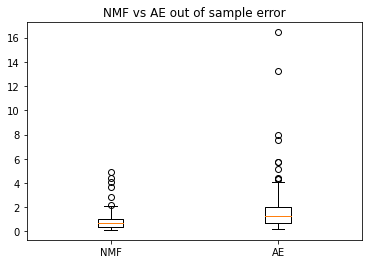

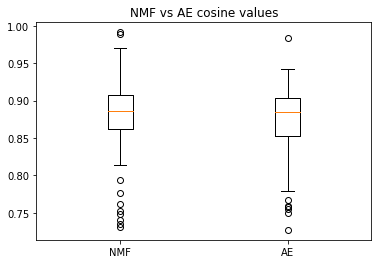

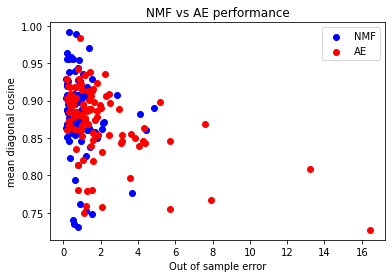

In [64]:
plt.boxplot(result[['outNMF', 'outAE']], labels = ["NMF", "AE"])
plt.title('NMF vs AE out of sample error')
plt.show()

plt.boxplot(result[['cosineNMF', 'cosineAE']] ,labels = ["NMF", "AE"])
plt.title('NMF vs AE cosine values')
plt.show()

plt.scatter(y = result['cosineNMF'], x = result['outNMF'], c = 'blue', label = 'NMF')
plt.scatter(y = result['cosineAE'], x = result['outAE'], c = 'red', label = 'AE')
plt.xlabel('Out of sample error')
plt.ylabel('mean diagonal cosine')
plt.title('NMF vs AE performance')
plt.legend()
plt.show()